In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from keras.optimizers import Adam

#image_size = (256,256)
#image_size = (400,400)
image_size = (512, 512)
bs = 1 

better_model = False
load_weights = False
losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard, sparse_accuracy_ignoring_last_label]}

backbone = 'mobilenetv2' #mobilenetv2, xception

NET = 'deeplab_' + backbone
#PATH = '/workspace/datasets/OpenSourceDatasets/VOCdevkit/VOC2012'
PATH = '/workspace/datasets/OpenSourceDatasets/freiburg_forest_annotated/processed'
impath ='images'
gtpath = 'groundtruth'

#n_classes = len(get_VOC2012_classes()) - 1
n_classes = 6

print('Num workers:', workers)
print('Backbone:', backbone)
print('Path to dataset:', PATH)
print('N classes:', n_classes)
print('Image size:', image_size)
print('Batch size:', bs)

SegClass = SegModel(PATH, image_size)
SegClass.set_batch_size(bs)

Using TensorFlow backend.


Num workers: 3
Backbone: mobilenetv2
Path to dataset: /workspace/datasets/OpenSourceDatasets/freiburg_forest_annotated/processed
N classes: 6
Image size: (512, 512)
Batch size: 1


## DeepLab V3+ And a SubPixel Upsampling Layer (better model) or Original

In [2]:
better_model=True
if better_model:
    model = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=load_weights, multi_gpu=False, backbone=backbone)
else:
    model = SegClass.create_seg_model(net='original',n=n_classes, load_weights=load_weights, multi_gpu=False, backbone=backbone)
    
model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
#print('Weights path:', SegClass.modelpath)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         lambda_1[0

### Train with generator

In [3]:
train_generator = SegClass.create_generators(impath=impath, gtpath=gtpath, blur = 5,crop_shape = None, mode = 'train', n_classes = n_classes,
                                             horizontal_flip = True, vertical_flip = False, brightness=0.3, 
                                             rotation=False, zoom=0.1, validation_split = .15, seed = 7, do_ahisteq = False)
valid_generator = SegClass.create_generators(impath=impath, gtpath=gtpath, blur = 0, crop_shape = None, mode = 'validation', 
                                             n_classes = n_classes, horizontal_flip = True, vertical_flip = False, 
                                             brightness=.1, rotation=False, zoom=.05, validation_split = .15, 
                                             seed = 7, do_ahisteq = False)

In [ ]:
monitor = 'Jaccard'
mode = 'max'
mp = True 
callback = True
'''
# fine-tune model (train only last conv layers)
flag = 0
for k, l in enumerate(model.layers):
    l.trainable = False
    if l.name == 'concat_projection':
        flag = 1
    if flag:
        l.trainable = True
'''     
def build_callbacks(tf_board = False):
    tensorboard = TensorBoard(log_dir=f'logs/{SegClass.net}', histogram_freq=0,
                        write_graph=False, write_images = False)
    checkpointer = ModelCheckpoint(filepath = SegClass.modelpath, verbose=1, save_best_only=True, save_weights_only=True,
                                    monitor = 'val_{}'.format(monitor), mode = mode)
    stop_train = EarlyStopping(monitor = 'val_{}'.format(monitor), patience=100, verbose=1, mode = mode)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_{}'.format(monitor), factor=0.5,
                patience=5, min_lr=1e-6)
    if tf_board:
        callbacks = [reduce_lr, stop_train, tensorboard]
    else:
        callbacks = [checkpointer, reduce_lr, stop_train]
    return callbacks

callbacks = build_callbacks(tf_board = callback)
        
SegClass.set_num_epochs(40)
history = SegClass.train_generator(model, train_generator, valid_generator, callbacks, mp = mp)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/40
196/196 [==============================] - 85s 436ms/step - loss: 1.0626 - Jaccard: 0.3754 - sparse_accuracy_ignoring_last_label: 0.5849 - val_loss: 4.8179 - val_Jaccard: 0.1970 - val_sparse_accuracy_ignoring_last_label: 0.3856
Epoch 2/40
196/196 [==============================] - 66s 339ms/step - loss: 0.6368 - Jaccard: 0.5925 - sparse_accuracy_ignoring_last_label: 0.7859 - val_loss: 2.8900 - val_Jaccard: 0.1824 - val_sparse_accuracy_ignoring_last_label: 0.3492
Epoch 3/40
196/196 [==============================] - 67s 340ms/step - loss: 0.5584 - Jaccard: 0.6232 - sparse_accuracy_ignoring_last_label: 0.7959 - val_loss: 1.9786 - val_Jaccard: 0.3297 - val_sparse_accuracy_ignoring_last_label: 0.5120
Epoch 4/40
 48/196 [======>.......................] - ETA: 47s - loss: 0.4635 - Jaccard: 0.6397 - sparse_accuracy_ignoring_last_label: 0.8109

### Compare Models

In [9]:
# Load original deeplab and subpixel-deeplab
model1 = SegClass.create_seg_model(net='original',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
model1.load_weights('weights/mobilenetv2_original.h5')
#model2 = SegClass.create_seg_model(net='subpixel',n=n_classes, load_weights=False, multi_gpu=False, backbone=backbone)
#model2.load_weights('weights/mobilenetv2_subpixel.h5')

In [10]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

"\nplt.subplot(144)\nMAP = do_crf(im, preds2, zero_unsure=False)\nplt.imshow(x[0].astype('uint8'))\nplt.imshow(MAP, alpha=.5)\nplt.title('Subpixel DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))\n"

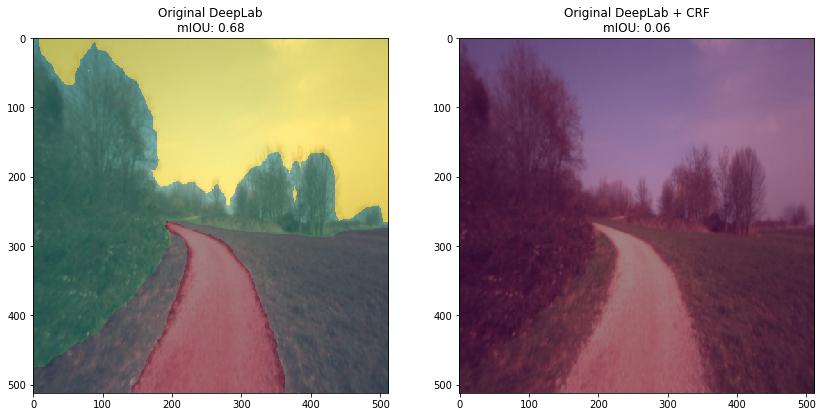

In [11]:
i = np.random.randint(0, len(valid_generator))
x,y,s = valid_generator.__getitem__(i)
preds1 = np.argmax(model1.predict(x), -1)[0].reshape(image_size)
#preds2 = np.argmax(model2.predict(x), -1)[0].reshape(image_size)

im = x[0].astype('uint8')
gt = y[0].reshape(image_size).astype('int32')

plt.figure(figsize=(14,10))
plt.subplot(121)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds1, alpha=.5)
plt.title('Original DeepLab\nmIOU: '+str(mIOU(gt, preds1)))
'''
plt.subplot(142)
plt.imshow(x[0].astype('uint8'))
plt.imshow(preds2, alpha=.5)
plt.title('Subpixel DeepLab\nmIOU: '+str(mIOU(gt, preds2)))
'''
plt.subplot(122)
MAP = do_crf(im, preds1, zero_unsure=False)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Original DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))
'''
plt.subplot(144)
MAP = do_crf(im, preds2, zero_unsure=False)
plt.imshow(x[0].astype('uint8'))
plt.imshow(MAP, alpha=.5)
plt.title('Subpixel DeepLab + CRF\nmIOU: '+str(mIOU(gt, MAP)))
'''

In [13]:
def calculate_iou(model, nb_classes = n_classes):
    SegClass.set_batch_size(1)
    valid_generator = SegClass.create_generators(impath=impath, gtpath=gtpath, blur = 0, crop_shape = None, mode = 'validation', 
                                             n_classes = n_classes, horizontal_flip = True, vertical_flip = False, 
                                             brightness=.1, rotation=False, zoom=.05, validation_split = .15, 
                                             seed = 7, do_ahisteq = False) 
    #valid_generator = SegClass.create_generators(crop_shape = None,mode = 'validation', n_classes = nb_classes, 
    #                                             horizontal_flip = False, vertical_flip = False,
    #                                             brightness=0, rotation=False,
    #                                             zoom=0, validation_split = .05, seed = 7, do_ahisteq = False)
    label = np.zeros((len(valid_generator),np.prod(image_size)), dtype='float32')
    X = np.zeros((len(valid_generator), image_size[0], image_size[1], 3), dtype='float32')
    for n in range(len(valid_generator)):
        x,y,_ = valid_generator.__getitem__(n)
        label[n,:] = y[0,:,0]
        X[n,:,:,:] = x
    preds = model.predict(X, batch_size=1)
    conf_m = np.zeros((nb_classes, nb_classes), dtype=float)
    total = 0
    mask = np.reshape(np.argmax(preds, axis=-1), (-1,) + image_size)
    flat_pred = np.ravel(mask).astype('int')
    flat_label = np.ravel(label).astype('int')
    for p, l in zip(flat_pred, flat_label):
        if l == nb_classes:
            continue
        if l < nb_classes and p < nb_classes:
            conf_m[l-1, p-1] += 1
        else:
            print('Invalid entry encountered, skipping! Label: ', l,
                    ' Prediction: ', p, ' Img_num: ', img_num)
    I = np.diag(conf_m)
    U = np.sum(conf_m, axis=0) + np.sum(conf_m, axis=1) - I
    IOU = I/U
    meanIOU = np.mean(IOU)
    return conf_m
conf_1 = calculate_iou(model1, nb_classes = n_classes)
#conf_2 = calculate_iou(model2, nb_classes = 21)

"\nplt.subplot(122)\ncm2=plot_confusion_matrix(conf_2, classes, normalize=True)\nplt.title('Subpixel DeepLab\nMean IOU: '+ str(np.round(np.diag(cm2).mean(), 2)))\n"

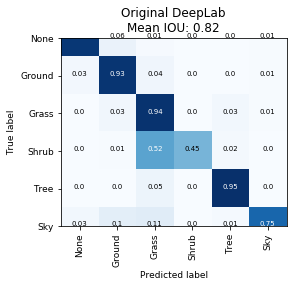

In [19]:
classes =['None','Ground','Grass','Shrub','Tree','Sky']
#classes = [c for c in get_VOC2012_classes().values()][:-1]
plt.figure(figsize=(4,4))
plt.subplot(111)
cm1=plot_confusion_matrix(conf_1, classes, normalize=True)
plt.title('Original DeepLab\nMean IOU: '+ str(np.round(np.diag(cm1).mean(), 2)))
'''
plt.subplot(122)
cm2=plot_confusion_matrix(conf_2, classes, normalize=True)
plt.title('Subpixel DeepLab\nMean IOU: '+ str(np.round(np.diag(cm2).mean(), 2)))
'''